In [1]:
"""
Looking for any barcodes that only differ on the YA
"""

import gzip
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from scipy import stats
import pingouin as pg
import pandas as pd


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return r_value**2


def Pearson_r(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return r_value

plt.rcParams["figure.figsize"] = (3.5,2.5)
figures_dir = "/JTE-607/Analysis/Figures/Revisions_1/"

In [2]:
"""
Search function for YA pairs of barcode regions within each backbone
"""
def search_YA_pairs(barcodes_set):
    Y_opposite_map = {"C": "T", "T": "C"}
    dinucleotide_pairs = {}  # barcode ending in C -> barcode ending in T
    for barcode in barcodes_set:
        if barcode[-1] in Y_opposite_map.keys():
            search_barcode = barcode[:-1] + Y_opposite_map[barcode[-1]]
            if search_barcode in barcodes_set:
                if barcode[-1] == "C":
                    dinucleotide_pairs[barcode] = search_barcode
                else:
                    dinucleotide_pairs[search_barcode] = barcode
    return dinucleotide_pairs


L3_barcodes_12p5uM = {}  # barcode -> 12p5uM_log_ratio
SVLst_barcodes_12p5uM = {}  # barcode -> 12p5uM_log_ratio
with gzip.open("/JTE-607/Analysis/Figures/JTE607_CNN_25nt_6epoch_4col_model_6/Figure_3/L3_SVLst_merged_logratios.csv.gz", "rt") as f:
    f.readline()  # throw away header
    for line in f:
        var = line.split()
        if var[5] == "L3":
            L3_barcodes_12p5uM[var[4][:13]] = float(var[3])
        elif var[5] == "SVLst":
            SVLst_barcodes_12p5uM[var[4][:12]] = float(var[3])

# find barcodes in each backbone that only differ on the YA
L3_barcodes_set = set(L3_barcodes_12p5uM.keys())
SVLst_barcodes_set = set(SVLst_barcodes_12p5uM.keys())
L3_dinucleotide_pairs = search_YA_pairs(L3_barcodes_set)
SVLst_dinucleotide_pairs = search_YA_pairs(SVLst_barcodes_set)

print("len(L3_dinucleotide_pairs.keys()) = ", len(L3_dinucleotide_pairs.keys()))
print("len(SVLst_dinucleotide_pairs.keys()) = ", len(SVLst_dinucleotide_pairs.keys()))


len(L3_dinucleotide_pairs.keys()) =  2513
len(SVLst_dinucleotide_pairs.keys()) =  3036


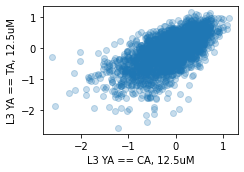

L3 Pearson R 12.5uM CA vs. TA =  0.6466978059334791
L3 mean 12.5uM CA vs. TA =  -0.12880510275136903 -0.07038052032503575
t-test ind L3 12.5uM CA vs. TA =  Ttest_indResult(statistic=-3.960678424394025, pvalue=7.577622106402554e-05)
Hedge's g, L3 12.5uM CA vs. TA =  -0.111718088183761
Cohen's d, L3 12.5uM CA vs. TA =  -0.11173476916447728
n =  2513


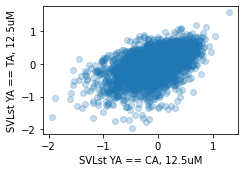

SVLst Pearson R 12.5uM CA vs. TA =  0.5192300333240737
SVLst mean 12.5uM CA vs. TA =  -0.06072825244392934 -0.017985456844592223
t-test ind SVLst 12.5uM CA vs. TA =  Ttest_indResult(statistic=-3.937656233544205, pvalue=8.320640920199666e-05)
Hedge's g =  -0.10105277554528985
Cohen's d =  -0.1010652635304042
n =  3036


<Figure size 252x180 with 0 Axes>

In [3]:
"""
Plot drug resistance at 12.5uM
"""

def get_XYlists(dinucleotide_pairs_dict, barcodes_vals_dict, clip_barcode=None):
    C_vals = []
    T_vals = []
    for C_barcode, T_barcode in dinucleotide_pairs_dict.items():
        if C_barcode in barcodes_vals_dict.keys() and T_barcode in barcodes_vals_dict.keys():
            C_vals.append(barcodes_vals_dict[C_barcode])
            T_vals.append(barcodes_vals_dict[T_barcode])
    return C_vals, T_vals

L3_C_12p5uM_vals, L3_T_12p5uM_vals = get_XYlists(L3_dinucleotide_pairs, L3_barcodes_12p5uM)
L3_Yprefix_12p5uM_df = pd.DataFrame(list(zip(L3_C_12p5uM_vals, L3_T_12p5uM_vals)), \
                              columns = ["L3_C_prefix_12p5uM_resistance", "L3_T_prefix_12p5uM_resistance"])
L3_Yprefix_12p5uM_df.to_csv('/JTE-607/Analysis/Figures/Source_Data/L3_Yprefix_12p5uM_resistance_df.tsv', sep="\t", index=True)

plt.scatter(L3_C_12p5uM_vals, L3_T_12p5uM_vals, alpha=0.25)
plt.xlabel("L3 YA == CA, 12.5uM")
plt.ylabel("L3 YA == TA, 12.5uM")
plt.tight_layout()
plt.savefig(figures_dir + "L3_YA_prefix_resistance_scatter.pdf")
plt.show()
plt.clf()
print("L3 Pearson R 12.5uM CA vs. TA = ", Pearson_r(L3_C_12p5uM_vals, L3_T_12p5uM_vals))
print("L3 mean 12.5uM CA vs. TA = ", np.mean(L3_C_12p5uM_vals), np.mean(L3_T_12p5uM_vals))
print("t-test ind L3 12.5uM CA vs. TA = ", stats.ttest_ind(L3_C_12p5uM_vals, L3_T_12p5uM_vals, equal_var=False))
print("Hedge's g, L3 12.5uM CA vs. TA = ", pg.compute_effsize(L3_C_12p5uM_vals, L3_T_12p5uM_vals, paired=True, eftype='hedges'))
print("Cohen's d, L3 12.5uM CA vs. TA = ", pg.compute_effsize(L3_C_12p5uM_vals, L3_T_12p5uM_vals, paired=True, eftype='cohen'))
print("n = ", len(L3_C_12p5uM_vals))

SVLst_C_12p5uM_vals, SVLst_T_12p5uM_vals = get_XYlists(SVLst_dinucleotide_pairs, SVLst_barcodes_12p5uM)
SVLst_Yprefix_12p5uM_df = pd.DataFrame(list(zip(SVLst_C_12p5uM_vals, SVLst_T_12p5uM_vals)), \
                              columns = ["SVLst_C_prefix_12p5uM_resistance", "SVLst_T_prefix_12p5uM_resistance"])
SVLst_Yprefix_12p5uM_df.to_csv('/JTE-607/Analysis/Figures/Source_Data/SVLst_Yprefix_12p5uM_resistance_df.tsv', sep="\t", index=True)

plt.scatter(SVLst_C_12p5uM_vals, SVLst_T_12p5uM_vals, alpha=0.25)
plt.xlabel("SVLst YA == CA, 12.5uM")
plt.ylabel("SVLst YA == TA, 12.5uM")
plt.tight_layout()
plt.savefig(figures_dir + "SVLst_YA_prefix_resistance_scatter.pdf")
plt.show()
plt.clf()
print("SVLst Pearson R 12.5uM CA vs. TA = ", Pearson_r(SVLst_C_12p5uM_vals, SVLst_T_12p5uM_vals))
print("SVLst mean 12.5uM CA vs. TA = ", np.mean(SVLst_C_12p5uM_vals), np.mean(SVLst_T_12p5uM_vals))
print("t-test ind SVLst 12.5uM CA vs. TA = ", stats.ttest_ind(SVLst_C_12p5uM_vals, SVLst_T_12p5uM_vals, equal_var=False))
print("Hedge's g = ", pg.compute_effsize(SVLst_C_12p5uM_vals, SVLst_T_12p5uM_vals, paired=True, eftype='hedges'))
print("Cohen's d = ", pg.compute_effsize(SVLst_C_12p5uM_vals, SVLst_T_12p5uM_vals, paired=True, eftype='cohen'))
print("n = ", len(SVLst_C_12p5uM_vals))


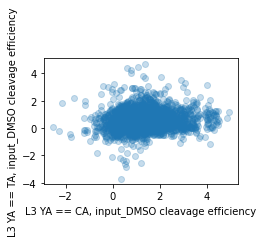

L3 Pearson R input_DMSO cleavage efficiency CA vs. TA =  0.11502007997836187
L3 mean input_DMSO cleavage efficiency CA vs. TA =  1.318461479728921 0.5785293108704761
t-test ind L3 input_DMSO cleavage efficiency CA vs. TA =  Ttest_indResult(statistic=30.32676949504538, pvalue=2.380468457049452e-184)
Hedge's g =  0.8554213055795958
Cohen's d =  0.8555490312374069
n =  2513


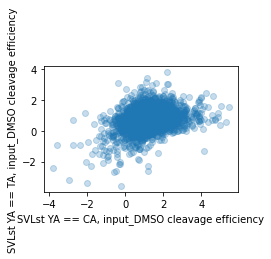

SVLst Pearson R input_DMSO cleavage efficiency CA vs. TA =  0.3140540872520142
SVLst mean input_DMSO cleavage efficiency CA vs. TA =  1.2247770791470882 0.7475430243344621
t-test ind SVLst input_DMSO cleavage efficiency CA vs. TA =  Ttest_indResult(statistic=23.818355099548846, pvalue=1.4820089558861156e-119)
Hedge's g =  0.6113553707897084
Cohen's d =  0.6114309462846964
n =  3035


<Figure size 252x180 with 0 Axes>

In [4]:
"""
Plot estimated cleavage efficiencies from DMSO and input
"""

from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import logit

# checking correlation between APARENT scores and input / DMSO reads
# calculating normalized input percentages, filtering for min coverage of 50 reads

def load_input_percentages(barcode_clusters_culled_file, min_cov=100):
    barcode_percents = {}
    with open(barcode_clusters_culled_file, "r") as f:
        f.readline()  # throw out header
        total_reads = 0
        for line in f:
            var = line.split("\t")
            barcode = var[0]
            coverage = float(var[2])
            total_reads += coverage
            if coverage >= min_cov:
                barcode_percents[barcode] = coverage

    for barcode, reads in barcode_percents.items():
        barcode_percents[barcode] = barcode_percents[barcode]/total_reads
    
    return barcode_percents


def load_DMSO_percentages_cutsite(PAS_read_counts_file, cut_site=46, min_cov=100):
    barcode_percents = {}
    with open(PAS_read_counts_file, "r") as f:
        total_reads = 0
        for line in f:
            var = line.split("\t")
            barcode = var[0]
            cut_pos = int(var[1])
            coverage = float(var[2])
            total_reads += coverage
            if coverage >= min_cov and cut_pos == cut_site:
                barcode_percents[barcode] = coverage

    for barcode, reads in barcode_percents.items():
        barcode_percents[barcode] = barcode_percents[barcode]/total_reads
    
    return barcode_percents


# L3 input
L3_barcode_clusters_culled_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/L3_input_barcode_clusters_consensus_seq_culled.txt"
L3_barcode_percents = load_input_percentages(L3_barcode_clusters_culled_file, min_cov=1)

# SVLst input
SVLst_barcode_clusters_culled_file = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/SVLst_input_barcode_clusters_consensus_seq_culled.txt"
SVLst_barcode_percents = load_input_percentages(SVLst_barcode_clusters_culled_file, min_cov=1)

# L3 DMSO
L3_DMSO_PAS_read_counts_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/L3_DMSO_polya_pos.txt"
L3_DMSO_barcode_percents = load_DMSO_percentages_cutsite(L3_DMSO_PAS_read_counts_file, cut_site=46, min_cov=1)

# SVLst DMSO
SVLst_DMSO_PAS_read_counts_file = "/JTE-607/Analysis/parsed_SVLst_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_SVLst_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/SVLst_DMSO_polya_pos.txt"
SVLst_DMSO_barcode_percents = load_DMSO_percentages_cutsite(SVLst_DMSO_PAS_read_counts_file, cut_site=46, min_cov=1)

# Calculate estimated cleavage rate = DMSO % / input %
# L3 estimated cleavage rate
L3_cleaved_enrichment = {}
for PAS, input_percentage in L3_barcode_percents.items():
    if PAS in L3_DMSO_barcode_percents:
        p = L3_DMSO_barcode_percents[PAS] / (L3_DMSO_barcode_percents[PAS] + L3_barcode_percents[PAS])
        L3_cleaved_enrichment[PAS] = logit(p)
    #else:
    #    L3_cleaved_enrichment[PAS] = 0

# SVLst estimated cleavage rate
SVLst_cleaved_enrichment = {}
for PAS, input_percentage in SVLst_barcode_percents.items():
    if PAS in SVLst_DMSO_barcode_percents:
        p = SVLst_DMSO_barcode_percents[PAS] / (SVLst_DMSO_barcode_percents[PAS] + SVLst_barcode_percents[PAS])
        SVLst_cleaved_enrichment[PAS] = logit(p)
    #else:
    #    SVLst_cleaved_enrichment[PAS] = 0
# cleanup
del SVLst_DMSO_barcode_percents, SVLst_barcode_percents, L3_DMSO_barcode_percents, L3_barcode_percents

# reduce measured cleavage efficiency dictionaries to relevant barcodes

L3_cleaved_enrichment = { k[:13]: v for k, v in L3_cleaved_enrichment.items() if k[:13] in L3_barcodes_set}
SVLst_cleaved_enrichment = { k[:12]: v for k, v in SVLst_cleaved_enrichment.items() if k[:12] in SVLst_barcodes_set}

# plot L3 measured efficiences for CA vs. TA
L3_C_input_DMSO_vals, L3_T_input_DMSO_vals = \
    get_XYlists(L3_dinucleotide_pairs, L3_cleaved_enrichment)
L3_Yprefix_input_DMSO_df = pd.DataFrame(list(zip(L3_C_input_DMSO_vals, L3_T_input_DMSO_vals)), \
                              columns = ["L3_C_prefix_input_DMSO_cleavage_efficiency", "L3_T_prefix_input_DMSO_cleavage_efficiency"])
L3_Yprefix_input_DMSO_df.to_csv('/JTE-607/Analysis/Figures/Source_Data/L3_Yprefix_input_DMSO_df.tsv', sep="\t", index=True)

plt.scatter(L3_C_input_DMSO_vals, L3_T_input_DMSO_vals, alpha=0.25)
plt.xlabel("L3 YA == CA, input_DMSO cleavage efficiency")
plt.ylabel("L3 YA == TA, input_DMSO cleavage efficiency")
plt.tight_layout()
plt.savefig(figures_dir + "L3_YA_prefix_input_DMSO_scatter.pdf")
plt.show()
plt.clf()
print("L3 Pearson R input_DMSO cleavage efficiency CA vs. TA = ", \
      Pearson_r(L3_C_input_DMSO_vals, L3_T_input_DMSO_vals))
print("L3 mean input_DMSO cleavage efficiency CA vs. TA = ", \
      np.mean(L3_C_input_DMSO_vals), np.mean(L3_T_input_DMSO_vals))
print("t-test ind L3 input_DMSO cleavage efficiency CA vs. TA = ", \
      stats.ttest_ind(L3_C_input_DMSO_vals, L3_T_input_DMSO_vals, equal_var=False))
print("Hedge's g = ", pg.compute_effsize(L3_C_input_DMSO_vals, L3_T_input_DMSO_vals, paired=True, eftype='hedges'))
print("Cohen's d = ", pg.compute_effsize(L3_C_input_DMSO_vals, L3_T_input_DMSO_vals, paired=True, eftype='cohen'))
print("n = ", len(L3_C_input_DMSO_vals))

# plot SVLst measured efficiences for CA vs. TA
SVLst_C_input_DMSO_vals, SVLst_T_input_DMSO_vals = \
    get_XYlists(SVLst_dinucleotide_pairs, SVLst_cleaved_enrichment)
SVLst_Yprefix_input_DMSO_df = pd.DataFrame(list(zip(SVLst_C_input_DMSO_vals, SVLst_T_input_DMSO_vals)), \
                              columns = ["SVLst_C_prefix_input_DMSO_cleavage_efficiency", "SVLst_T_prefix_input_DMSO_cleavage_efficiency"])
SVLst_Yprefix_input_DMSO_df.to_csv('/JTE-607/Analysis/Figures/Source_Data/SVLst_Yprefix_input_DMSO_df.tsv', sep="\t", index=True)

plt.scatter(SVLst_C_input_DMSO_vals, SVLst_T_input_DMSO_vals, alpha=0.25)
plt.xlabel("SVLst YA == CA, input_DMSO cleavage efficiency")
plt.ylabel("SVLst YA == TA, input_DMSO cleavage efficiency")
plt.tight_layout()
plt.savefig(figures_dir + "SVLst_YA_prefix_input_DMSO_scatter.pdf")
plt.show()
plt.clf()
print("SVLst Pearson R input_DMSO cleavage efficiency CA vs. TA = ", \
      Pearson_r(SVLst_C_input_DMSO_vals, SVLst_T_input_DMSO_vals))
print("SVLst mean input_DMSO cleavage efficiency CA vs. TA = ", \
      np.mean(SVLst_C_input_DMSO_vals), np.mean(SVLst_T_input_DMSO_vals))
print("t-test ind SVLst input_DMSO cleavage efficiency CA vs. TA = ", \
      stats.ttest_ind(SVLst_C_input_DMSO_vals, SVLst_T_input_DMSO_vals, equal_var=False))
print("Hedge's g = ", pg.compute_effsize(SVLst_C_input_DMSO_vals, SVLst_T_input_DMSO_vals, paired=True, eftype='hedges'))
print("Cohen's d = ", pg.compute_effsize(SVLst_C_input_DMSO_vals, SVLst_T_input_DMSO_vals, paired=True, eftype='cohen'))
print("n = ", len(SVLst_C_input_DMSO_vals))


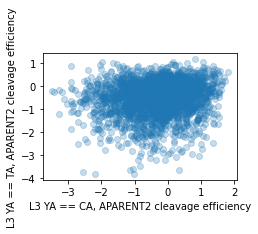

L3 Pearson R APARENT2 cleavage efficiency CA vs. TA =  0.14307986340922693
L3 mean APARENT2 cleavage efficiency CA vs. TA =  -0.3182190092635544 -0.539861802940254
t-test ind L3 APARENT2 cleavage efficiency CA vs. TA =  Ttest_indResult(statistic=9.471334846983934, pvalue=4.215219341301352e-21)
Hedge's g =  0.2671561051602339
Cohen's d =  0.26719599508236613
n =  2513


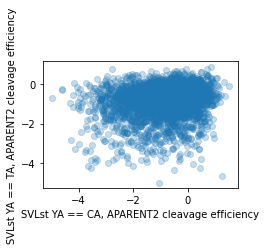

SVLst Pearson R APARENT2 cleavage efficiency CA vs. TA =  0.16392435476145337
SVLst mean APARENT2 cleavage efficiency CA vs. TA =  -0.9050026875622222 -0.8985596842234329
t-test ind SVLst APARENT2 cleavage efficiency CA vs. TA =  Ttest_indResult(statistic=-0.2711881355553659, pvalue=0.7862560553296151)
Hedge's g =  -0.006959549581644398
Cohen's d =  -0.006960409634731601
n =  3036


<Figure size 252x180 with 0 Axes>

In [5]:
"""
Plot APARENT2 cleavage efficiencies
"""

# parsing through APARENT scores
APARENT_score_file = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose/collapsed/all_DMSO_sequences_shifted_pred.csv"
L3_APARENT_iso_pred_cut_nuc_scores_dict = {}  # PAS_barcode -> APARENT score
SVLst_APARENT_iso_pred_cut_nuc_scores_dict = {}  # PAS_barcode -> APARENT score

with open(APARENT_score_file, "r") as f:
    f.readline()  # throw out header
    for line in f:
        var = line.split("\t")
        sequence = var[0]
        iso_pred_cut_nuc = float(var[14])  # iso_pred_cut_nuc
        PAS = sequence[76:101]  # b/c shifted to same location in APARENT
        if sequence[:3] == "NNN":
            # L3 variant
            if PAS[:13] in L3_barcodes_12p5uM:
                L3_APARENT_iso_pred_cut_nuc_scores_dict[PAS[:13]] = iso_pred_cut_nuc
        else:
            # SVLst variant
            if PAS[:12] in SVLst_barcodes_12p5uM:
                SVLst_APARENT_iso_pred_cut_nuc_scores_dict[PAS[:12]] = iso_pred_cut_nuc


L3_C_APARENT2_vals, L3_T_APARENT2_vals = get_XYlists(L3_dinucleotide_pairs, L3_APARENT_iso_pred_cut_nuc_scores_dict)
L3_Yprefix_APARENT2_df = pd.DataFrame(list(zip(L3_C_APARENT2_vals, L3_T_APARENT2_vals)), \
                              columns = ["L3_C_prefix_APARENT2_cleavage_efficiency", "L3_T_prefix_APARENT2_cleavage_efficiency"])
L3_Yprefix_APARENT2_df.to_csv('/JTE-607/Analysis/Figures/Source_Data/L3_Yprefix_APARENT2_df.tsv', sep="\t", index=True)

plt.scatter(L3_C_APARENT2_vals, L3_T_APARENT2_vals, alpha=0.25)
plt.xlabel("L3 YA == CA, APARENT2 cleavage efficiency")
plt.ylabel("L3 YA == TA, APARENT2 cleavage efficiency")
plt.tight_layout()
plt.savefig(figures_dir + "L3_YA_prefix_APARENT2_scatter.pdf")
plt.show()
plt.clf()
print("L3 Pearson R APARENT2 cleavage efficiency CA vs. TA = ", \
      Pearson_r(L3_C_APARENT2_vals, L3_T_APARENT2_vals))
print("L3 mean APARENT2 cleavage efficiency CA vs. TA = ", \
      np.mean(L3_C_APARENT2_vals), np.mean(L3_T_APARENT2_vals))
print("t-test ind L3 APARENT2 cleavage efficiency CA vs. TA = ", \
      stats.ttest_ind(L3_C_APARENT2_vals, L3_T_APARENT2_vals, equal_var=False))
print("Hedge's g = ", pg.compute_effsize(L3_C_APARENT2_vals, L3_T_APARENT2_vals, paired=True, eftype='hedges'))
print("Cohen's d = ", pg.compute_effsize(L3_C_APARENT2_vals, L3_T_APARENT2_vals, paired=True, eftype='cohen'))
print("n = ", len(L3_C_APARENT2_vals))

SVLst_C_APARENT2_vals, SVLst_T_APARENT2_vals = \
    get_XYlists(SVLst_dinucleotide_pairs, SVLst_APARENT_iso_pred_cut_nuc_scores_dict)
SVLst_Yprefix_APARENT2_df = pd.DataFrame(list(zip(SVLst_C_APARENT2_vals, SVLst_T_APARENT2_vals)), \
                              columns = ["SVLst_C_prefix_APARENT2_cleavage_efficiency", "SVLst_T_prefix_APARENT2_cleavage_efficiency"])
SVLst_Yprefix_APARENT2_df.to_csv('/JTE-607/Analysis/Figures/Source_Data/SVLst_Yprefix_APARENT2_df.tsv', sep="\t", index=True)

plt.scatter(SVLst_C_APARENT2_vals, SVLst_T_APARENT2_vals, alpha=0.25)
plt.xlabel("SVLst YA == CA, APARENT2 cleavage efficiency")
plt.ylabel("SVLst YA == TA, APARENT2 cleavage efficiency")
plt.tight_layout()
plt.savefig(figures_dir + "SVLst_YA_prefix_APARENT2_scatter.pdf")
plt.show()
plt.clf()
print("SVLst Pearson R APARENT2 cleavage efficiency CA vs. TA = ", \
      Pearson_r(SVLst_C_APARENT2_vals, SVLst_T_APARENT2_vals))
print("SVLst mean APARENT2 cleavage efficiency CA vs. TA = ", \
      np.mean(SVLst_C_APARENT2_vals), np.mean(SVLst_T_APARENT2_vals))
print("t-test ind SVLst APARENT2 cleavage efficiency CA vs. TA = ", \
      stats.ttest_ind(SVLst_C_APARENT2_vals, SVLst_T_APARENT2_vals, equal_var=False))
print("Hedge's g = ", pg.compute_effsize(SVLst_C_APARENT2_vals, SVLst_T_APARENT2_vals, paired=True, eftype='hedges'))
print("Cohen's d = ", pg.compute_effsize(SVLst_C_APARENT2_vals, SVLst_T_APARENT2_vals, paired=True, eftype='cohen'))
print("n = ", len(SVLst_C_APARENT2_vals))
